# Exercise 2: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 3 parts:

1. Python warmup: working with images, refresher on classes and objects.
2. Implementing loss functions, calculating gradients and implementing gradient descent.
3. Training and evaluating several classifiers.

## Submission guidelines:

Your zip should include the following files only:
```
- HW2.pdf
- HW2.ipynb
- functions/
    - classifier.py
    - losses.py
```
Name the file `ex2_ID.zip` if you submit alone of `ex2_ID1_ID2.zip` if you submit in pairs. Do **not** include the data. 

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Write **efficient vectorized** code whenever instructed. 
1. You should add as many tests as you see fit. Tests will not be graded nor checked.
1. Do not change the functions we provided you. 
1. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only.
1. Your code must run without errors. Use `python 3` and at least `numpy 1.15.4`. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. 
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

In [159]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functions.classifier import LinearPerceptron
from functions.classifier import LogisticRegression
from functions.losses import perceptron_loss_vectorized
from functions.losses import perceptron_loss_naive
from functions.losses import binary_cross_entropy
from functions.losses import grad_check

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.4
Numpy version:  1.16.4


## Data preprocessing
The next few cells will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization (learning rate and L2 regularization). We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [3]:
from datasets import load_cifar10
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ('plane', 'car')

(10000, 3073)
(1000, 3073)
(1000, 3073)


          car           car         plane           car


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


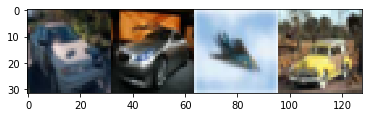

In [5]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

## Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Open the file `functions/classifier.py` and make sure you understand the code. You might find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class. In this exercise, we will define our Linear perceptron to have two outputs - one outputs for each class.      

Open the file `functions/classifier.py`. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(2.5 points)**

In [6]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

          car         plane           car         plane


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


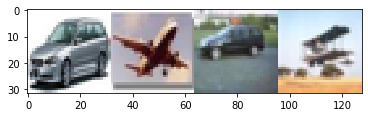

In [7]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [8]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane           car         plane         plane


## Evaluation

Complete the class method `calc_accuracy` in `functions/classifier.py`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(2.5 points)**

In [9]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  [0.4704]


Your answer here:

## Hinge loss (30 points)

Your code for this section will all be written inside `functions/losses.py`. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in `losses.py`. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W.

In [10]:
W = np.random.randn(3073, 2) * 0.001

In [26]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 1.816776
CPU times: user 13.2 ms, sys: 1.28 ms, total: 14.5 ms
Wall time: 13.7 ms


You are provided with a gradient checking function called `grad_check` in `functions/losses.py`. The following cells test your implementation of the loss value and gradient. Errors should be below $10^{-8}$.

In [27]:
loss, grad = perceptron_loss_naive(W, X_val, y_val)
f = lambda w: perceptron_loss_naive(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: -6.060511 analytic: -6.060511, relative error: 4.484043e-12
numerical: -4.099380 analytic: -4.099380, relative error: 1.355327e-12
numerical: -0.981590 analytic: -0.981590, relative error: 2.313270e-12
numerical: -5.075406 analytic: -5.075406, relative error: 1.341348e-13
numerical: 1.028618 analytic: 1.028618, relative error: 1.040856e-11
numerical: 5.290649 analytic: 5.290649, relative error: 1.200035e-11
numerical: 2.334474 analytic: 2.334474, relative error: 7.736694e-13
numerical: -6.060991 analytic: -6.060991, relative error: 4.869602e-12
numerical: -5.009046 analytic: -5.009046, relative error: 2.693413e-12
numerical: 9.520549 analytic: 9.520549, relative error: 1.080399e-12


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below.

In [33]:
%%time
loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

loss: 1.816776
difference: 0.000000
CPU times: user 14.5 ms, sys: 1.78 ms, total: 16.3 ms
Wall time: 11 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in `functions/classifier.py`. This function should be implemented in the `LinearClassifier` class. (**10 points**)

In [45]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 567.003661
iteration 100 / 1500: loss 696.298451
iteration 200 / 1500: loss 600.695164
iteration 300 / 1500: loss 659.117602
iteration 400 / 1500: loss 661.002926
iteration 500 / 1500: loss 548.582472
iteration 600 / 1500: loss 589.677598
iteration 700 / 1500: loss 584.249174
iteration 800 / 1500: loss 603.406284
iteration 900 / 1500: loss 703.661724
iteration 1000 / 1500: loss 477.738859
iteration 1100 / 1500: loss 684.492812
iteration 1200 / 1500: loss 621.274364
iteration 1300 / 1500: loss 610.388993
iteration 1400 / 1500: loss 653.240904
CPU times: user 4.37 s, sys: 176 ms, total: 4.54 s
Wall time: 2.43 s


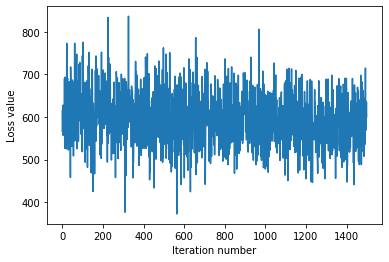

In [46]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [48]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  [0.477]
Testing accuracy:  [0.497]


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [52]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
epochs = 200*600/X_train.shape[0]
for lr in learning_rates:
    for bs in batch_sizes:
        num_iters = int(epochs*X_train.shape[0]/bs)
        lp = LinearPerceptron(X_train, y_train)
        _ = lp.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        val_accuracy = lp.calc_accuracy(X_val, y_val)
        train_accuracy = lp.calc_accuracy(X_train, y_train)
        results[(lr, bs)] = (train_accuracy,val_accuracy)
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_perceptron = lp
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))


print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

iteration 0 / 120000: loss 0.000000
iteration 100 / 120000: loss 0.000000
iteration 200 / 120000: loss 0.000000
iteration 300 / 120000: loss 0.000000
iteration 400 / 120000: loss 0.000000
iteration 500 / 120000: loss 0.000000
iteration 600 / 120000: loss 862.847664
iteration 700 / 120000: loss 0.000000
iteration 800 / 120000: loss 0.000000
iteration 900 / 120000: loss 0.000000
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss 0.000000
iteration 1200 / 120000: loss 0.000000
iteration 1300 / 120000: loss 0.000000
iteration 1400 / 120000: loss 0.000000
iteration 1500 / 120000: loss 0.000000
iteration 1600 / 120000: loss 512.181336
iteration 1700 / 120000: loss 0.000000
iteration 1800 / 120000: loss 2147.166099
iteration 1900 / 120000: loss 0.000000
iteration 2000 / 120000: loss 0.000000
iteration 2100 / 120000: loss 0.000000
iteration 2200 / 120000: loss 0.000000
iteration 2300 / 120000: loss 1010.789232
iteration 2400 / 120000: loss 0.000000
iteration 2500 / 120000: lo

iteration 21400 / 120000: loss 1705.301481
iteration 21500 / 120000: loss 0.000000
iteration 21600 / 120000: loss 418.933676
iteration 21700 / 120000: loss 431.222503
iteration 21800 / 120000: loss 0.000000
iteration 21900 / 120000: loss 0.000000
iteration 22000 / 120000: loss 0.000000
iteration 22100 / 120000: loss 0.000000
iteration 22200 / 120000: loss 0.000000
iteration 22300 / 120000: loss 0.000000
iteration 22400 / 120000: loss 0.000000
iteration 22500 / 120000: loss 0.000000
iteration 22600 / 120000: loss 0.000000
iteration 22700 / 120000: loss 203.248383
iteration 22800 / 120000: loss 0.000000
iteration 22900 / 120000: loss 1136.613498
iteration 23000 / 120000: loss 770.531108
iteration 23100 / 120000: loss 908.672395
iteration 23200 / 120000: loss 216.455331
iteration 23300 / 120000: loss 0.000000
iteration 23400 / 120000: loss 0.000000
iteration 23500 / 120000: loss 0.000000
iteration 23600 / 120000: loss 0.000000
iteration 23700 / 120000: loss 0.000000
iteration 23800 / 1200

iteration 42700 / 120000: loss 0.000000
iteration 42800 / 120000: loss 55.415691
iteration 42900 / 120000: loss 0.000000
iteration 43000 / 120000: loss 888.778748
iteration 43100 / 120000: loss 0.000000
iteration 43200 / 120000: loss 674.243157
iteration 43300 / 120000: loss 0.000000
iteration 43400 / 120000: loss 0.000000
iteration 43500 / 120000: loss 0.000000
iteration 43600 / 120000: loss 423.460443
iteration 43700 / 120000: loss 0.000000
iteration 43800 / 120000: loss 0.000000
iteration 43900 / 120000: loss 345.756284
iteration 44000 / 120000: loss 357.145134
iteration 44100 / 120000: loss 0.000000
iteration 44200 / 120000: loss 0.000000
iteration 44300 / 120000: loss 0.000000
iteration 44400 / 120000: loss 0.000000
iteration 44500 / 120000: loss 0.000000
iteration 44600 / 120000: loss 0.000000
iteration 44700 / 120000: loss 0.000000
iteration 44800 / 120000: loss 0.000000
iteration 44900 / 120000: loss 0.000000
iteration 45000 / 120000: loss 0.000000
iteration 45100 / 120000: los

iteration 64100 / 120000: loss 0.000000
iteration 64200 / 120000: loss 0.000000
iteration 64300 / 120000: loss 456.742529
iteration 64400 / 120000: loss 31.261694
iteration 64500 / 120000: loss 562.271317
iteration 64600 / 120000: loss 0.000000
iteration 64700 / 120000: loss 458.093639
iteration 64800 / 120000: loss 553.988699
iteration 64900 / 120000: loss 0.000000
iteration 65000 / 120000: loss 0.000000
iteration 65100 / 120000: loss 0.000000
iteration 65200 / 120000: loss 0.000000
iteration 65300 / 120000: loss 906.012150
iteration 65400 / 120000: loss 0.000000
iteration 65500 / 120000: loss 0.000000
iteration 65600 / 120000: loss 101.198879
iteration 65700 / 120000: loss 0.000000
iteration 65800 / 120000: loss 0.000000
iteration 65900 / 120000: loss 83.332784
iteration 66000 / 120000: loss 840.770045
iteration 66100 / 120000: loss 0.000000
iteration 66200 / 120000: loss 0.000000
iteration 66300 / 120000: loss 0.000000
iteration 66400 / 120000: loss 34.767832
iteration 66500 / 12000

iteration 85100 / 120000: loss 0.000000
iteration 85200 / 120000: loss 676.140094
iteration 85300 / 120000: loss 0.000000
iteration 85400 / 120000: loss 447.338455
iteration 85500 / 120000: loss 384.573266
iteration 85600 / 120000: loss 0.000000
iteration 85700 / 120000: loss 0.000000
iteration 85800 / 120000: loss 461.877467
iteration 85900 / 120000: loss 0.000000
iteration 86000 / 120000: loss 0.000000
iteration 86100 / 120000: loss 449.822149
iteration 86200 / 120000: loss 0.000000
iteration 86300 / 120000: loss 0.000000
iteration 86400 / 120000: loss 837.110438
iteration 86500 / 120000: loss 0.000000
iteration 86600 / 120000: loss 277.506196
iteration 86700 / 120000: loss 0.000000
iteration 86800 / 120000: loss 313.477635
iteration 86900 / 120000: loss 142.352021
iteration 87000 / 120000: loss 100.580975
iteration 87100 / 120000: loss 0.000000
iteration 87200 / 120000: loss 0.000000
iteration 87300 / 120000: loss 0.000000
iteration 87400 / 120000: loss 0.000000
iteration 87500 / 12

iteration 106700 / 120000: loss 0.000000
iteration 106800 / 120000: loss 0.000000
iteration 106900 / 120000: loss 0.000000
iteration 107000 / 120000: loss 0.000000
iteration 107100 / 120000: loss 1593.077640
iteration 107200 / 120000: loss 0.000000
iteration 107300 / 120000: loss 0.000000
iteration 107400 / 120000: loss 0.000000
iteration 107500 / 120000: loss 630.415869
iteration 107600 / 120000: loss 0.000000
iteration 107700 / 120000: loss 0.000000
iteration 107800 / 120000: loss 461.766364
iteration 107900 / 120000: loss 0.000000
iteration 108000 / 120000: loss 0.000000
iteration 108100 / 120000: loss 0.000000
iteration 108200 / 120000: loss 592.187707
iteration 108300 / 120000: loss 0.000000
iteration 108400 / 120000: loss 0.000000
iteration 108500 / 120000: loss 0.000000
iteration 108600 / 120000: loss 0.000000
iteration 108700 / 120000: loss 0.000000
iteration 108800 / 120000: loss 0.000000
iteration 108900 / 120000: loss 0.000000
iteration 109000 / 120000: loss 200.040984
itera

iteration 6700 / 120000: loss 0.000000
iteration 6800 / 120000: loss 0.000000
iteration 6900 / 120000: loss 0.000000
iteration 7000 / 120000: loss 1363.679844
iteration 7100 / 120000: loss 0.000000
iteration 7200 / 120000: loss 0.000000
iteration 7300 / 120000: loss 0.000000
iteration 7400 / 120000: loss 0.000000
iteration 7500 / 120000: loss 0.000000
iteration 7600 / 120000: loss 0.000000
iteration 7700 / 120000: loss 29.004709
iteration 7800 / 120000: loss 0.000000
iteration 7900 / 120000: loss 0.000000
iteration 8000 / 120000: loss 770.622360
iteration 8100 / 120000: loss 0.000000
iteration 8200 / 120000: loss 0.000000
iteration 8300 / 120000: loss 0.000000
iteration 8400 / 120000: loss 214.296158
iteration 8500 / 120000: loss 174.705809
iteration 8600 / 120000: loss 0.000000
iteration 8700 / 120000: loss 0.000000
iteration 8800 / 120000: loss 0.000000
iteration 8900 / 120000: loss 0.000000
iteration 9000 / 120000: loss 0.000000
iteration 9100 / 120000: loss 0.000000
iteration 9200 

iteration 27400 / 120000: loss 0.000000
iteration 27500 / 120000: loss 0.000000
iteration 27600 / 120000: loss 11.592741
iteration 27700 / 120000: loss 0.000000
iteration 27800 / 120000: loss 0.000000
iteration 27900 / 120000: loss 274.903035
iteration 28000 / 120000: loss 0.000000
iteration 28100 / 120000: loss 0.000000
iteration 28200 / 120000: loss 0.000000
iteration 28300 / 120000: loss 0.000000
iteration 28400 / 120000: loss 0.000000
iteration 28500 / 120000: loss 0.000000
iteration 28600 / 120000: loss 587.227565
iteration 28700 / 120000: loss 492.381295
iteration 28800 / 120000: loss 0.000000
iteration 28900 / 120000: loss 494.455507
iteration 29000 / 120000: loss 429.735237
iteration 29100 / 120000: loss 0.000000
iteration 29200 / 120000: loss 0.000000
iteration 29300 / 120000: loss 0.000000
iteration 29400 / 120000: loss 142.638376
iteration 29500 / 120000: loss 0.000000
iteration 29600 / 120000: loss 0.000000
iteration 29700 / 120000: loss 0.000000
iteration 29800 / 120000: l

iteration 47900 / 120000: loss 0.000000
iteration 48000 / 120000: loss 85.451273
iteration 48100 / 120000: loss 0.000000
iteration 48200 / 120000: loss 0.000000
iteration 48300 / 120000: loss 0.000000
iteration 48400 / 120000: loss 0.000000
iteration 48500 / 120000: loss 0.000000
iteration 48600 / 120000: loss 0.000000
iteration 48700 / 120000: loss 0.000000
iteration 48800 / 120000: loss 177.898434
iteration 48900 / 120000: loss 0.000000
iteration 49000 / 120000: loss 0.000000
iteration 49100 / 120000: loss 0.000000
iteration 49200 / 120000: loss 0.000000
iteration 49300 / 120000: loss 0.000000
iteration 49400 / 120000: loss 0.000000
iteration 49500 / 120000: loss 0.000000
iteration 49600 / 120000: loss 131.499936
iteration 49700 / 120000: loss 417.190927
iteration 49800 / 120000: loss 563.482673
iteration 49900 / 120000: loss 0.000000
iteration 50000 / 120000: loss 0.000000
iteration 50100 / 120000: loss 0.000000
iteration 50200 / 120000: loss 0.000000
iteration 50300 / 120000: loss 

iteration 68700 / 120000: loss 0.000000
iteration 68800 / 120000: loss 170.479571
iteration 68900 / 120000: loss 0.000000
iteration 69000 / 120000: loss 0.000000
iteration 69100 / 120000: loss 0.000000
iteration 69200 / 120000: loss 88.132440
iteration 69300 / 120000: loss 0.000000
iteration 69400 / 120000: loss 0.000000
iteration 69500 / 120000: loss 0.000000
iteration 69600 / 120000: loss 0.000000
iteration 69700 / 120000: loss 0.000000
iteration 69800 / 120000: loss 0.000000
iteration 69900 / 120000: loss 0.000000
iteration 70000 / 120000: loss 0.000000
iteration 70100 / 120000: loss 0.000000
iteration 70200 / 120000: loss 0.000000
iteration 70300 / 120000: loss 0.000000
iteration 70400 / 120000: loss 0.000000
iteration 70500 / 120000: loss 0.000000
iteration 70600 / 120000: loss 0.000000
iteration 70700 / 120000: loss 0.000000
iteration 70800 / 120000: loss 0.000000
iteration 70900 / 120000: loss 0.000000
iteration 71000 / 120000: loss 0.000000
iteration 71100 / 120000: loss 0.0000

iteration 89600 / 120000: loss 0.000000
iteration 89700 / 120000: loss 107.413264
iteration 89800 / 120000: loss 0.000000
iteration 89900 / 120000: loss 0.000000
iteration 90000 / 120000: loss 0.000000
iteration 90100 / 120000: loss 0.000000
iteration 90200 / 120000: loss 0.000000
iteration 90300 / 120000: loss 0.000000
iteration 90400 / 120000: loss 0.000000
iteration 90500 / 120000: loss 0.000000
iteration 90600 / 120000: loss 85.372465
iteration 90700 / 120000: loss 0.000000
iteration 90800 / 120000: loss 0.000000
iteration 90900 / 120000: loss 0.000000
iteration 91000 / 120000: loss 0.000000
iteration 91100 / 120000: loss 0.000000
iteration 91200 / 120000: loss 0.000000
iteration 91300 / 120000: loss 0.000000
iteration 91400 / 120000: loss 0.000000
iteration 91500 / 120000: loss 0.000000
iteration 91600 / 120000: loss 0.000000
iteration 91700 / 120000: loss 0.000000
iteration 91800 / 120000: loss 0.000000
iteration 91900 / 120000: loss 426.515011
iteration 92000 / 120000: loss 0.00

iteration 110800 / 120000: loss 0.000000
iteration 110900 / 120000: loss 0.000000
iteration 111000 / 120000: loss 280.380761
iteration 111100 / 120000: loss 0.000000
iteration 111200 / 120000: loss 0.000000
iteration 111300 / 120000: loss 0.000000
iteration 111400 / 120000: loss 43.939007
iteration 111500 / 120000: loss 0.000000
iteration 111600 / 120000: loss 0.000000
iteration 111700 / 120000: loss 0.000000
iteration 111800 / 120000: loss 0.000000
iteration 111900 / 120000: loss 0.000000
iteration 112000 / 120000: loss 0.000000
iteration 112100 / 120000: loss 0.000000
iteration 112200 / 120000: loss 256.902049
iteration 112300 / 120000: loss 0.000000
iteration 112400 / 120000: loss 0.000000
iteration 112500 / 120000: loss 0.000000
iteration 112600 / 120000: loss 0.000000
iteration 112700 / 120000: loss 0.000000
iteration 112800 / 120000: loss 0.000000
iteration 112900 / 120000: loss 0.000000
iteration 113000 / 120000: loss 0.000000
iteration 113100 / 120000: loss 0.000000
iteration 1

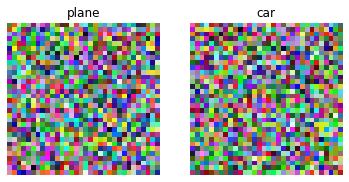

In [53]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 2)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. (**2.5 points**)

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [76]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

        plane           car           car         plane


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


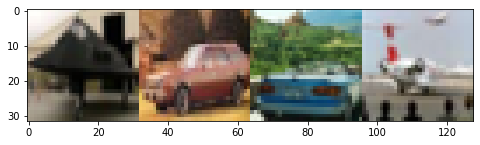

In [77]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [78]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane           car           car           car


## Evaluation

Complete the class method `calc_accuracy` in the `LinearClassifier` located in `functions/classifier.py`. (**2.5 points**)

In [80]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  [0.5796]


## Binary cross-entropy (30 points)

Your code for this section will all be written inside **functions/losses.py**. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W. (**10 points**)

In [135]:
W = np.random.randn(3073, 1) * 0.0001

In [148]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 675.952212
CPU times: user 11.6 ms, sys: 3.58 ms, total: 15.1 ms
Wall time: 16.5 ms


In [149]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 12254.677088 analytic: 12254.676922, relative error: 6.743897e-09
numerical: -2843.607026 analytic: -2843.607107, relative error: 1.417219e-08
numerical: 4454.527029 analytic: 4454.526992, relative error: 4.234694e-09
numerical: 8577.605982 analytic: 8577.606004, relative error: 1.293165e-09
numerical: 11957.008517 analytic: 11957.008528, relative error: 4.560905e-10
numerical: 11614.737426 analytic: 11614.737330, relative error: 4.166928e-09
numerical: 8755.382205 analytic: 8755.381998, relative error: 1.186841e-08
numerical: 13658.173337 analytic: 13658.173215, relative error: 4.458530e-09
numerical: 534.284930 analytic: 534.284785, relative error: 1.357876e-07
numerical: 8124.478488 analytic: 8124.478271, relative error: 1.336456e-08


If implemented correctly, the training procedure you already implemented should work.

In [150]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 152.995856
iteration 100 / 1500: loss 714.079604
iteration 200 / 1500: loss 282.805945
iteration 300 / 1500: loss 314.450220
iteration 400 / 1500: loss 852.251995
iteration 500 / 1500: loss 148.653884
iteration 600 / 1500: loss 366.819065
iteration 700 / 1500: loss 219.586917
iteration 800 / 1500: loss 85.142033
iteration 900 / 1500: loss 152.118032
iteration 1000 / 1500: loss 389.980677
iteration 1100 / 1500: loss 643.958543
iteration 1200 / 1500: loss 146.844491
iteration 1300 / 1500: loss 202.859145
iteration 1400 / 1500: loss 836.625430
CPU times: user 4.61 s, sys: 324 ms, total: 4.94 s
Wall time: 2.67 s


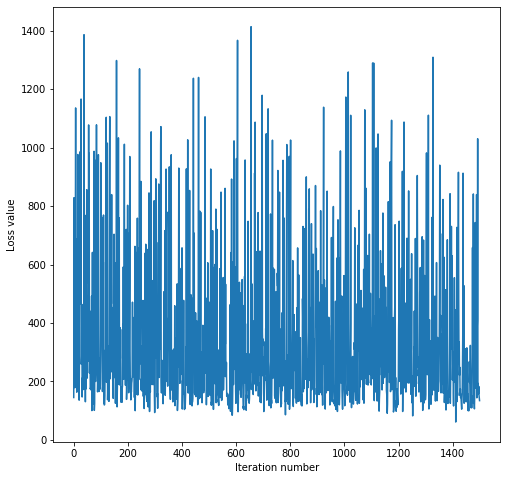

In [140]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [145]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  [0.8053]
Testing accuracy:  [0.804]


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [155]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 1000, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

epochs = 200*600/X_train.shape[0]

for lr in learning_rates:
    for bs in batch_sizes:
        
        num_iters = int(epochs*X_train.shape[0]/bs)
        lr_classifier = LogisticRegression(X_train, y_train)
        
        _ = lr_classifier.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        
        val_accuracy = lr_classifier.calc_accuracy(X_val, y_val)
        train_accuracy = lr_classifier.calc_accuracy(X_train, y_train)
        
        print('(lr, bs) = {}'.format((lr, bs)))
        print('(val_accuracy,train_accuracy, best_val) = {}'.format((val_accuracy, train_accuracy, best_val)))

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_logistic = lr_classifier
        results[(lr, bs)] = (train_accuracy,val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

iteration 0 / 120000: loss 0.510205
iteration 100 / 120000: loss 0.761476
iteration 200 / 120000: loss 1.264493
iteration 300 / 120000: loss 1.095027
iteration 400 / 120000: loss 1.050029
iteration 500 / 120000: loss 0.458279
iteration 600 / 120000: loss 0.220641
iteration 700 / 120000: loss 0.165147
iteration 800 / 120000: loss 0.014918
iteration 900 / 120000: loss 1.399836
iteration 1000 / 120000: loss 1.058271
iteration 1100 / 120000: loss 0.358603
iteration 1200 / 120000: loss 0.007780
iteration 1300 / 120000: loss 0.158842
iteration 1400 / 120000: loss 2.350961
iteration 1500 / 120000: loss 0.429368
iteration 1600 / 120000: loss 0.268336
iteration 1700 / 120000: loss 0.165167
iteration 1800 / 120000: loss 0.574513
iteration 1900 / 120000: loss 0.504218
iteration 2000 / 120000: loss 0.858677
iteration 2100 / 120000: loss 0.239370
iteration 2200 / 120000: loss 0.231505
iteration 2300 / 120000: loss 0.146539
iteration 2400 / 120000: loss 0.085568
iteration 2500 / 120000: loss 0.83589

iteration 21900 / 120000: loss 0.246745
iteration 22000 / 120000: loss 0.070205
iteration 22100 / 120000: loss 1.197329
iteration 22200 / 120000: loss 0.277815
iteration 22300 / 120000: loss 0.069844
iteration 22400 / 120000: loss 0.279978
iteration 22500 / 120000: loss 0.467296
iteration 22600 / 120000: loss 0.392829
iteration 22700 / 120000: loss 0.324019
iteration 22800 / 120000: loss 1.008880
iteration 22900 / 120000: loss 0.263505
iteration 23000 / 120000: loss 0.127649
iteration 23100 / 120000: loss 0.030542
iteration 23200 / 120000: loss 0.989215
iteration 23300 / 120000: loss 0.020384
iteration 23400 / 120000: loss 0.249012
iteration 23500 / 120000: loss 0.558178
iteration 23600 / 120000: loss 0.159513
iteration 23700 / 120000: loss 0.010345
iteration 23800 / 120000: loss 0.012517
iteration 23900 / 120000: loss 0.676055
iteration 24000 / 120000: loss 0.341307
iteration 24100 / 120000: loss 0.007585
iteration 24200 / 120000: loss 0.087348
iteration 24300 / 120000: loss 0.200998


iteration 45100 / 120000: loss 1.760650
iteration 45200 / 120000: loss 0.020588
iteration 45300 / 120000: loss 0.230240
iteration 45400 / 120000: loss 0.192414
iteration 45500 / 120000: loss 0.391369
iteration 45600 / 120000: loss 0.899351
iteration 45700 / 120000: loss 0.016213
iteration 45800 / 120000: loss 0.048513
iteration 45900 / 120000: loss 0.730975
iteration 46000 / 120000: loss 0.019370
iteration 46100 / 120000: loss 0.713486
iteration 46200 / 120000: loss 0.214040
iteration 46300 / 120000: loss 1.036266
iteration 46400 / 120000: loss 0.155737
iteration 46500 / 120000: loss 0.021147
iteration 46600 / 120000: loss 1.296038
iteration 46700 / 120000: loss 0.089689
iteration 46800 / 120000: loss 5.739792
iteration 46900 / 120000: loss 0.511687
iteration 47000 / 120000: loss 0.171667
iteration 47100 / 120000: loss 0.017870
iteration 47200 / 120000: loss 0.030824
iteration 47300 / 120000: loss 0.010048
iteration 47400 / 120000: loss 0.027398
iteration 47500 / 120000: loss 0.030220


iteration 68000 / 120000: loss 0.007567
iteration 68100 / 120000: loss 0.000803
iteration 68200 / 120000: loss 0.076200
iteration 68300 / 120000: loss 0.006940
iteration 68400 / 120000: loss 0.176687
iteration 68500 / 120000: loss 0.008180
iteration 68600 / 120000: loss 0.121119
iteration 68700 / 120000: loss 2.228628
iteration 68800 / 120000: loss 0.666588
iteration 68900 / 120000: loss 0.339733
iteration 69000 / 120000: loss 0.927941
iteration 69100 / 120000: loss 2.357864
iteration 69200 / 120000: loss 0.100946
iteration 69300 / 120000: loss 0.048354
iteration 69400 / 120000: loss 0.000155
iteration 69500 / 120000: loss 0.012136
iteration 69600 / 120000: loss 0.260576
iteration 69700 / 120000: loss 0.064021
iteration 69800 / 120000: loss 0.012452
iteration 69900 / 120000: loss 1.578661
iteration 70000 / 120000: loss 0.260074
iteration 70100 / 120000: loss 0.006143
iteration 70200 / 120000: loss 0.013298
iteration 70300 / 120000: loss 0.534524
iteration 70400 / 120000: loss 0.005277


iteration 90500 / 120000: loss 0.472099
iteration 90600 / 120000: loss 0.182840
iteration 90700 / 120000: loss 0.002511
iteration 90800 / 120000: loss 0.213720
iteration 90900 / 120000: loss 1.627729
iteration 91000 / 120000: loss 0.081091
iteration 91100 / 120000: loss 0.118228
iteration 91200 / 120000: loss 0.001774
iteration 91300 / 120000: loss 0.252197
iteration 91400 / 120000: loss 0.436149
iteration 91500 / 120000: loss 0.122146
iteration 91600 / 120000: loss 2.388886
iteration 91700 / 120000: loss 1.366912
iteration 91800 / 120000: loss 0.281909
iteration 91900 / 120000: loss 0.179741
iteration 92000 / 120000: loss 0.238409
iteration 92100 / 120000: loss 0.165569
iteration 92200 / 120000: loss 0.160778
iteration 92300 / 120000: loss 1.588679
iteration 92400 / 120000: loss 0.080259
iteration 92500 / 120000: loss 0.018966
iteration 92600 / 120000: loss 1.553794
iteration 92700 / 120000: loss 0.241759
iteration 92800 / 120000: loss 0.073708
iteration 92900 / 120000: loss 0.006512


iteration 113400 / 120000: loss 0.394229
iteration 113500 / 120000: loss 0.408935
iteration 113600 / 120000: loss 0.609569
iteration 113700 / 120000: loss 0.282871
iteration 113800 / 120000: loss 0.022774
iteration 113900 / 120000: loss 0.011573
iteration 114000 / 120000: loss 0.115105
iteration 114100 / 120000: loss 0.194266
iteration 114200 / 120000: loss 0.270040
iteration 114300 / 120000: loss 0.014443
iteration 114400 / 120000: loss 0.129603
iteration 114500 / 120000: loss 0.398395
iteration 114600 / 120000: loss 0.009019
iteration 114700 / 120000: loss 0.086377
iteration 114800 / 120000: loss 0.541309
iteration 114900 / 120000: loss 0.000049
iteration 115000 / 120000: loss 0.511357
iteration 115100 / 120000: loss 0.014335
iteration 115200 / 120000: loss 0.012475
iteration 115300 / 120000: loss 0.403257
iteration 115400 / 120000: loss 0.183823
iteration 115500 / 120000: loss 0.024390
iteration 115600 / 120000: loss 0.226284
iteration 115700 / 120000: loss 0.062490
iteration 115800

iteration 12600 / 120000: loss 0.000000
iteration 12700 / 120000: loss 0.077495
iteration 12800 / 120000: loss 0.000000
iteration 12900 / 120000: loss 0.000356
iteration 13000 / 120000: loss 0.080557
iteration 13100 / 120000: loss 0.000000
iteration 13200 / 120000: loss 0.000000
iteration 13300 / 120000: loss 29.302869
iteration 13400 / 120000: loss 26.409406
iteration 13500 / 120000: loss 69.060391
iteration 13600 / 120000: loss 95.540490
iteration 13700 / 120000: loss 0.000000
iteration 13800 / 120000: loss 0.000000
iteration 13900 / 120000: loss 0.000000
iteration 14000 / 120000: loss 0.000000
iteration 14100 / 120000: loss 0.000000
iteration 14200 / 120000: loss 0.000000
iteration 14300 / 120000: loss 0.000000
iteration 14400 / 120000: loss 0.000000
iteration 14500 / 120000: loss 0.000000
iteration 14600 / 120000: loss 0.000000
iteration 14700 / 120000: loss 0.000000
iteration 14800 / 120000: loss 84.946586
iteration 14900 / 120000: loss 26.384528
iteration 15000 / 120000: loss 0.0

iteration 34100 / 120000: loss 0.000000
iteration 34200 / 120000: loss 0.000000
iteration 34300 / 120000: loss 0.000000
iteration 34400 / 120000: loss 0.000000
iteration 34500 / 120000: loss 28.946522
iteration 34600 / 120000: loss 0.000000
iteration 34700 / 120000: loss 23.871638
iteration 34800 / 120000: loss 0.000000
iteration 34900 / 120000: loss 0.000000
iteration 35000 / 120000: loss 0.000000
iteration 35100 / 120000: loss 0.000000
iteration 35200 / 120000: loss 0.014745
iteration 35300 / 120000: loss 0.000000
iteration 35400 / 120000: loss 0.000000
iteration 35500 / 120000: loss 0.000000
iteration 35600 / 120000: loss 0.000000
iteration 35700 / 120000: loss 13.919396
iteration 35800 / 120000: loss 0.000000
iteration 35900 / 120000: loss 0.000000
iteration 36000 / 120000: loss 0.000000
iteration 36100 / 120000: loss 0.000161
iteration 36200 / 120000: loss 0.000000
iteration 36300 / 120000: loss 0.000000
iteration 36400 / 120000: loss 0.000000
iteration 36500 / 120000: loss 0.0000

iteration 55900 / 120000: loss 0.001135
iteration 56000 / 120000: loss 9.088777
iteration 56100 / 120000: loss 0.000000
iteration 56200 / 120000: loss 8.056406
iteration 56300 / 120000: loss 34.420329
iteration 56400 / 120000: loss 34.243888
iteration 56500 / 120000: loss 0.210814
iteration 56600 / 120000: loss 0.000866
iteration 56700 / 120000: loss 0.000000
iteration 56800 / 120000: loss 9.278233
iteration 56900 / 120000: loss 0.000000
iteration 57000 / 120000: loss 0.000000
iteration 57100 / 120000: loss 0.000000
iteration 57200 / 120000: loss 0.000000
iteration 57300 / 120000: loss 0.000000
iteration 57400 / 120000: loss 0.000000
iteration 57500 / 120000: loss 6.662219
iteration 57600 / 120000: loss 0.000000
iteration 57700 / 120000: loss 38.281565
iteration 57800 / 120000: loss 0.000000
iteration 57900 / 120000: loss 0.000000
iteration 58000 / 120000: loss 23.165877
iteration 58100 / 120000: loss 0.000000
iteration 58200 / 120000: loss 0.000000
iteration 58300 / 120000: loss 0.000

iteration 77400 / 120000: loss 55.589749
iteration 77500 / 120000: loss 0.000000
iteration 77600 / 120000: loss 0.000000
iteration 77700 / 120000: loss 32.177837
iteration 77800 / 120000: loss 0.000000
iteration 77900 / 120000: loss 39.082530
iteration 78000 / 120000: loss 0.000000
iteration 78100 / 120000: loss 0.001716
iteration 78200 / 120000: loss 0.000000
iteration 78300 / 120000: loss 0.000000
iteration 78400 / 120000: loss 0.000000
iteration 78500 / 120000: loss 28.487019
iteration 78600 / 120000: loss 0.000000
iteration 78700 / 120000: loss 0.000000
iteration 78800 / 120000: loss 30.033931
iteration 78900 / 120000: loss 0.000001
iteration 79000 / 120000: loss 66.991094
iteration 79100 / 120000: loss 0.000000
iteration 79200 / 120000: loss 0.000000
iteration 79300 / 120000: loss 0.000000
iteration 79400 / 120000: loss 0.000000
iteration 79500 / 120000: loss 0.000000
iteration 79600 / 120000: loss 0.000000
iteration 79700 / 120000: loss 0.000005
iteration 79800 / 120000: loss 0.0

iteration 98700 / 120000: loss 0.000000
iteration 98800 / 120000: loss 0.000000
iteration 98900 / 120000: loss 0.006070
iteration 99000 / 120000: loss 0.000000
iteration 99100 / 120000: loss 0.000000
iteration 99200 / 120000: loss 9.836871
iteration 99300 / 120000: loss 0.000000
iteration 99400 / 120000: loss 0.000000
iteration 99500 / 120000: loss 0.000000
iteration 99600 / 120000: loss 0.000000
iteration 99700 / 120000: loss 0.000000
iteration 99800 / 120000: loss 14.723391
iteration 99900 / 120000: loss 0.000000
iteration 100000 / 120000: loss 0.000000
iteration 100100 / 120000: loss 0.000000
iteration 100200 / 120000: loss 0.000000
iteration 100300 / 120000: loss 0.000000
iteration 100400 / 120000: loss 0.000000
iteration 100500 / 120000: loss 23.229754
iteration 100600 / 120000: loss 0.000084
iteration 100700 / 120000: loss 0.000000
iteration 100800 / 120000: loss 0.000000
iteration 100900 / 120000: loss 9.221116
iteration 101000 / 120000: loss 0.000000
iteration 101100 / 120000: 

iteration 100 / 1200: loss 7132.244055
iteration 200 / 1200: loss 2707.585265
iteration 300 / 1200: loss 3287.510468
iteration 400 / 1200: loss inf
iteration 500 / 1200: loss 1169.138934
iteration 600 / 1200: loss 2109.695660
iteration 700 / 1200: loss 2439.770909
iteration 800 / 1200: loss 3607.228302
iteration 900 / 1200: loss inf
iteration 1000 / 1200: loss 2611.966596
iteration 1100 / 1200: loss 6855.206217
(lr, bs) = (5e-06, 100)
(val_accuracy,train_accuracy, best_val) = (array([0.322]), array([0.733]), array([0.409]))
iteration 0 / 600: loss 147.262512
iteration 100 / 600: loss 8314.501238
iteration 200 / 600: loss inf
iteration 300 / 600: loss inf
iteration 400 / 600: loss inf
iteration 500 / 600: loss 12113.607108
(lr, bs) = (5e-06, 200)
(val_accuracy,train_accuracy, best_val) = (array([0.377]), array([0.8234]), array([0.409]))
iteration 0 / 240: loss 375.683764
iteration 100 / 240: loss inf
iteration 200 / 240: loss inf
(lr, bs) = (5e-06, 500)
(val_accuracy,train_accuracy, bes

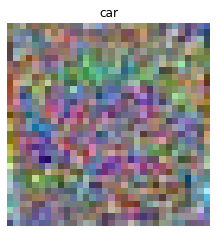

In [156]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Explain the possible reasons for the differences in the visualization of the weights in the both cases.

Both models are trying to solve the same problem but they are doing it in diffrenet ways. 
1. They use diffrent loss function
2. Diffrent activation function. 

The loss functions are similar at the edges but are diffrent in the middle.
So they are optimized to lear diffrent things so the weights will look diffrent.

Bonus (**10 points**): Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. For this part, implement L2 regularization of the form:
$$
Loss = Loss + \lambda \cdot \sum_{i=0}^k w_k^2
$$
Where $\lambda$ is yet another hyper parameter. Search for an optimal $\lambda$ (look around 5e4) and don't forget to update the gradient or the regularization won't effect the weights. When you are finished, train a perceptron classifier and visualize the weights. What do you see?

In [168]:
from functions.classifier import LinearPerceptronRegularization
from functions.losses import perceptron_loss_vectorized_with_regularization

learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 10000]
regularizarion_rates = [6e-4, 5e-4, 4e-4, 3e-4]

results = {}
best_val = -1   
best_perceptron_regularized = None 

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
epochs = 200*600/X_train.shape[0]
for lr in learning_rates:
    for bs in batch_sizes:
        for regularization_rate in regularizarion_rates:
            print('lr={} bs={} regularization_rate={}'.format(lr, bs, regularization_rate))
            num_iters = int(epochs*X_train.shape[0]/bs)
            lpr = LinearPerceptronRegularization(X_train, y_train, regularization_rate)
            _ = lpr.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
            val_accuracy = lpr.calc_accuracy(X_val, y_val)
            train_accuracy = lpr.calc_accuracy(X_train, y_train)
            results[(lr, bs, regularization_rate)] = (train_accuracy,val_accuracy)

            if val_accuracy > best_val:
                best_val = val_accuracy
                best_perceptron_regularized = lpr
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size, regularization_rate in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size, regularization_rate)]
    print ('lr %e batch_size %e regularization_rate %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, regularization_rate, train_accuracy, val_accuracy))


print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron_regularized.calc_accuracy(X_test, y_test)
print ('linear perceptron regularized on raw pixels final test set accuracy: %f' % test_accuracy)

lr=1e-07 bs=1 regularization_rate=0.0006
iteration 0 / 120000: loss 0.905209
iteration 100 / 120000: loss 0.000000
iteration 200 / 120000: loss 0.000000
iteration 300 / 120000: loss 0.000000
iteration 400 / 120000: loss 0.000000
iteration 500 / 120000: loss 0.000000
iteration 600 / 120000: loss 0.671257
iteration 700 / 120000: loss 1.721766
iteration 800 / 120000: loss 4.600748
iteration 900 / 120000: loss 0.000000
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss 0.203816
iteration 1200 / 120000: loss 0.000000
iteration 1300 / 120000: loss 0.000000
iteration 1400 / 120000: loss 4.682065
iteration 1500 / 120000: loss 0.000000
iteration 1600 / 120000: loss 1.178074
iteration 1700 / 120000: loss 0.000000
iteration 1800 / 120000: loss 0.000000
iteration 1900 / 120000: loss 0.000000
iteration 2000 / 120000: loss 0.000000
iteration 2100 / 120000: loss 0.000000
iteration 2200 / 120000: loss 0.000000
iteration 2300 / 120000: loss 0.000000
iteration 2400 / 120000: loss 3.070

iteration 21100 / 120000: loss 0.841548
iteration 21200 / 120000: loss 0.435267
iteration 21300 / 120000: loss 0.592241
iteration 21400 / 120000: loss 0.000000
iteration 21500 / 120000: loss 0.000000
iteration 21600 / 120000: loss 0.000000
iteration 21700 / 120000: loss 0.680275
iteration 21800 / 120000: loss 0.000000
iteration 21900 / 120000: loss 0.000000
iteration 22000 / 120000: loss 0.000000
iteration 22100 / 120000: loss 0.000000
iteration 22200 / 120000: loss 0.000000
iteration 22300 / 120000: loss 0.000000
iteration 22400 / 120000: loss 0.094857
iteration 22500 / 120000: loss 0.000000
iteration 22600 / 120000: loss 0.236736
iteration 22700 / 120000: loss 0.000000
iteration 22800 / 120000: loss 3.175702
iteration 22900 / 120000: loss 7.396120
iteration 23000 / 120000: loss 0.000000
iteration 23100 / 120000: loss 0.000000
iteration 23200 / 120000: loss 0.000000
iteration 23300 / 120000: loss 0.000000
iteration 23400 / 120000: loss 2.052702
iteration 23500 / 120000: loss 0.000000


iteration 41700 / 120000: loss 0.000000
iteration 41800 / 120000: loss 0.000000
iteration 41900 / 120000: loss 5.557993
iteration 42000 / 120000: loss 0.000000
iteration 42100 / 120000: loss 0.000000
iteration 42200 / 120000: loss 0.000000
iteration 42300 / 120000: loss 0.000000
iteration 42400 / 120000: loss 1.481809
iteration 42500 / 120000: loss 6.549686
iteration 42600 / 120000: loss 0.000000
iteration 42700 / 120000: loss 0.975159
iteration 42800 / 120000: loss 0.000000
iteration 42900 / 120000: loss 0.000000
iteration 43000 / 120000: loss 0.000000
iteration 43100 / 120000: loss 0.000000
iteration 43200 / 120000: loss 0.000000
iteration 43300 / 120000: loss 0.000000
iteration 43400 / 120000: loss 0.387482
iteration 43500 / 120000: loss 0.000000
iteration 43600 / 120000: loss 0.000000
iteration 43700 / 120000: loss 0.000000
iteration 43800 / 120000: loss 0.000000
iteration 43900 / 120000: loss 0.000000
iteration 44000 / 120000: loss 0.000000
iteration 44100 / 120000: loss 0.000000


iteration 62400 / 120000: loss 0.000000
iteration 62500 / 120000: loss 0.000000
iteration 62600 / 120000: loss 4.399128
iteration 62700 / 120000: loss 0.000000
iteration 62800 / 120000: loss 3.210533
iteration 62900 / 120000: loss 0.172265
iteration 63000 / 120000: loss 0.000000
iteration 63100 / 120000: loss 0.700138
iteration 63200 / 120000: loss 0.000000
iteration 63300 / 120000: loss 0.000000
iteration 63400 / 120000: loss 0.000000
iteration 63500 / 120000: loss 0.000000
iteration 63600 / 120000: loss 0.000000
iteration 63700 / 120000: loss 0.000000
iteration 63800 / 120000: loss 1.702093
iteration 63900 / 120000: loss 0.000000
iteration 64000 / 120000: loss 0.250274
iteration 64100 / 120000: loss 0.000000
iteration 64200 / 120000: loss 4.713487
iteration 64300 / 120000: loss 0.000000
iteration 64400 / 120000: loss 0.000000
iteration 64500 / 120000: loss 0.000000
iteration 64600 / 120000: loss 0.000000
iteration 64700 / 120000: loss 0.000000
iteration 64800 / 120000: loss 0.000000


iteration 83300 / 120000: loss 0.002083
iteration 83400 / 120000: loss 0.000001
iteration 83500 / 120000: loss 0.000001
iteration 83600 / 120000: loss 0.000001
iteration 83700 / 120000: loss 8.677646
iteration 83800 / 120000: loss 0.000001
iteration 83900 / 120000: loss 0.000001
iteration 84000 / 120000: loss 0.000001
iteration 84100 / 120000: loss 0.000001
iteration 84200 / 120000: loss 0.000001
iteration 84300 / 120000: loss 0.000001
iteration 84400 / 120000: loss 0.000001
iteration 84500 / 120000: loss 0.000001
iteration 84600 / 120000: loss 0.000001
iteration 84700 / 120000: loss 0.000001
iteration 84800 / 120000: loss 0.000001
iteration 84900 / 120000: loss 0.567392
iteration 85000 / 120000: loss 0.000001
iteration 85100 / 120000: loss 1.249000
iteration 85200 / 120000: loss 4.319012
iteration 85300 / 120000: loss 0.000001
iteration 85400 / 120000: loss 0.000001
iteration 85500 / 120000: loss 0.000001
iteration 85600 / 120000: loss 0.000001
iteration 85700 / 120000: loss 0.000001


iteration 104200 / 120000: loss 0.000001
iteration 104300 / 120000: loss 0.000001
iteration 104400 / 120000: loss 0.288296
iteration 104500 / 120000: loss 0.000001
iteration 104600 / 120000: loss 0.000001
iteration 104700 / 120000: loss 0.000001
iteration 104800 / 120000: loss 0.000001
iteration 104900 / 120000: loss 0.000001
iteration 105000 / 120000: loss 0.254204
iteration 105100 / 120000: loss 0.000001
iteration 105200 / 120000: loss 0.000001
iteration 105300 / 120000: loss 0.000001
iteration 105400 / 120000: loss 0.000001
iteration 105500 / 120000: loss 0.000001
iteration 105600 / 120000: loss 3.224323
iteration 105700 / 120000: loss 0.006141
iteration 105800 / 120000: loss 0.000001
iteration 105900 / 120000: loss 4.086488
iteration 106000 / 120000: loss 1.589497
iteration 106100 / 120000: loss 0.000001
iteration 106200 / 120000: loss 0.000001
iteration 106300 / 120000: loss 0.000001
iteration 106400 / 120000: loss 0.296796
iteration 106500 / 120000: loss 0.000001
iteration 106600

iteration 5000 / 120000: loss 3.062584
iteration 5100 / 120000: loss 3.527494
iteration 5200 / 120000: loss 0.000000
iteration 5300 / 120000: loss 0.000000
iteration 5400 / 120000: loss 1.565038
iteration 5500 / 120000: loss 0.000000
iteration 5600 / 120000: loss 0.000000
iteration 5700 / 120000: loss 0.000000
iteration 5800 / 120000: loss 0.000000
iteration 5900 / 120000: loss 0.000000
iteration 6000 / 120000: loss 0.000000
iteration 6100 / 120000: loss 0.000000
iteration 6200 / 120000: loss 0.000000
iteration 6300 / 120000: loss 4.659628
iteration 6400 / 120000: loss 0.000000
iteration 6500 / 120000: loss 1.911584
iteration 6600 / 120000: loss 0.000000
iteration 6700 / 120000: loss 0.000000
iteration 6800 / 120000: loss 0.000000
iteration 6900 / 120000: loss 2.361429
iteration 7000 / 120000: loss 0.000000
iteration 7100 / 120000: loss 1.435373
iteration 7200 / 120000: loss 4.396291
iteration 7300 / 120000: loss 0.000000
iteration 7400 / 120000: loss 0.000000
iteration 7500 / 120000: 

iteration 26200 / 120000: loss 0.000000
iteration 26300 / 120000: loss 0.000000
iteration 26400 / 120000: loss 0.000000
iteration 26500 / 120000: loss 0.000000
iteration 26600 / 120000: loss 0.000000
iteration 26700 / 120000: loss 0.000000
iteration 26800 / 120000: loss 0.000000
iteration 26900 / 120000: loss 2.276575
iteration 27000 / 120000: loss 0.000000
iteration 27100 / 120000: loss 0.000000
iteration 27200 / 120000: loss 0.000000
iteration 27300 / 120000: loss 0.000000
iteration 27400 / 120000: loss 2.867922
iteration 27500 / 120000: loss 0.000000
iteration 27600 / 120000: loss 0.000000
iteration 27700 / 120000: loss 2.038304
iteration 27800 / 120000: loss 0.000000
iteration 27900 / 120000: loss 0.000000
iteration 28000 / 120000: loss 2.176847
iteration 28100 / 120000: loss 0.000000
iteration 28200 / 120000: loss 0.000000
iteration 28300 / 120000: loss 0.000000
iteration 28400 / 120000: loss 0.000000
iteration 28500 / 120000: loss 0.000000
iteration 28600 / 120000: loss 0.000000


iteration 47100 / 120000: loss 0.000000
iteration 47200 / 120000: loss 0.000000
iteration 47300 / 120000: loss 0.879255
iteration 47400 / 120000: loss 0.000000
iteration 47500 / 120000: loss 0.000000
iteration 47600 / 120000: loss 0.000000
iteration 47700 / 120000: loss 0.582532
iteration 47800 / 120000: loss 0.397561
iteration 47900 / 120000: loss 0.000000
iteration 48000 / 120000: loss 0.000000
iteration 48100 / 120000: loss 0.000000
iteration 48200 / 120000: loss 0.212009
iteration 48300 / 120000: loss 0.000000
iteration 48400 / 120000: loss 0.000000
iteration 48500 / 120000: loss 0.000000
iteration 48600 / 120000: loss 0.000000
iteration 48700 / 120000: loss 2.345600
iteration 48800 / 120000: loss 0.000000
iteration 48900 / 120000: loss 1.195547
iteration 49000 / 120000: loss 0.000000
iteration 49100 / 120000: loss 0.000000
iteration 49200 / 120000: loss 0.000000
iteration 49300 / 120000: loss 0.000000
iteration 49400 / 120000: loss 0.000000
iteration 49500 / 120000: loss 0.000000


iteration 67600 / 120000: loss 2.069745
iteration 67700 / 120000: loss 0.000000
iteration 67800 / 120000: loss 0.000000
iteration 67900 / 120000: loss 0.000000
iteration 68000 / 120000: loss 1.904574
iteration 68100 / 120000: loss 0.000000
iteration 68200 / 120000: loss 0.000000
iteration 68300 / 120000: loss 4.353833
iteration 68400 / 120000: loss 0.000000
iteration 68500 / 120000: loss 11.703421
iteration 68600 / 120000: loss 0.000000
iteration 68700 / 120000: loss 0.000000
iteration 68800 / 120000: loss 0.000000
iteration 68900 / 120000: loss 0.000000
iteration 69000 / 120000: loss 0.000000
iteration 69100 / 120000: loss 0.000000
iteration 69200 / 120000: loss 1.042351
iteration 69300 / 120000: loss 0.000000
iteration 69400 / 120000: loss 0.000000
iteration 69500 / 120000: loss 0.000000
iteration 69600 / 120000: loss 3.351186
iteration 69700 / 120000: loss 0.000000
iteration 69800 / 120000: loss 0.000000
iteration 69900 / 120000: loss 0.000000
iteration 70000 / 120000: loss 0.000000

iteration 88600 / 120000: loss 3.698239
iteration 88700 / 120000: loss 0.000000
iteration 88800 / 120000: loss 0.000000
iteration 88900 / 120000: loss 1.215268
iteration 89000 / 120000: loss 5.922478
iteration 89100 / 120000: loss 0.000000
iteration 89200 / 120000: loss 7.883893
iteration 89300 / 120000: loss 0.748953
iteration 89400 / 120000: loss 0.000000
iteration 89500 / 120000: loss 0.000000
iteration 89600 / 120000: loss 0.000000
iteration 89700 / 120000: loss 0.000000
iteration 89800 / 120000: loss 0.000000
iteration 89900 / 120000: loss 0.000000
iteration 90000 / 120000: loss 0.000000
iteration 90100 / 120000: loss 1.479114
iteration 90200 / 120000: loss 0.094174
iteration 90300 / 120000: loss 0.000000
iteration 90400 / 120000: loss 0.517083
iteration 90500 / 120000: loss 0.000000
iteration 90600 / 120000: loss 0.000000
iteration 90700 / 120000: loss 0.000000
iteration 90800 / 120000: loss 0.000000
iteration 90900 / 120000: loss 0.000000
iteration 91000 / 120000: loss 0.000000


iteration 109400 / 120000: loss 0.000001
iteration 109500 / 120000: loss 0.000001
iteration 109600 / 120000: loss 2.394559
iteration 109700 / 120000: loss 0.504500
iteration 109800 / 120000: loss 0.000001
iteration 109900 / 120000: loss 0.000001
iteration 110000 / 120000: loss 0.000001
iteration 110100 / 120000: loss 0.000001
iteration 110200 / 120000: loss 0.000001
iteration 110300 / 120000: loss 0.000001
iteration 110400 / 120000: loss 1.324245
iteration 110500 / 120000: loss 1.807034
iteration 110600 / 120000: loss 0.000001
iteration 110700 / 120000: loss 0.831422
iteration 110800 / 120000: loss 0.000001
iteration 110900 / 120000: loss 0.000001
iteration 111000 / 120000: loss 0.000001
iteration 111100 / 120000: loss 0.000001
iteration 111200 / 120000: loss 0.000001
iteration 111300 / 120000: loss 0.000001
iteration 111400 / 120000: loss 0.000001
iteration 111500 / 120000: loss 1.712764
iteration 111600 / 120000: loss 0.000001
iteration 111700 / 120000: loss 0.568666
iteration 111800

iteration 10300 / 120000: loss 2.553830
iteration 10400 / 120000: loss 3.677239
iteration 10500 / 120000: loss 6.724882
iteration 10600 / 120000: loss 5.869838
iteration 10700 / 120000: loss 3.020048
iteration 10800 / 120000: loss 0.000000
iteration 10900 / 120000: loss 0.061555
iteration 11000 / 120000: loss 0.310766
iteration 11100 / 120000: loss 0.000000
iteration 11200 / 120000: loss 0.000000
iteration 11300 / 120000: loss 2.744021
iteration 11400 / 120000: loss 0.935701
iteration 11500 / 120000: loss 0.000000
iteration 11600 / 120000: loss 0.000000
iteration 11700 / 120000: loss 0.000000
iteration 11800 / 120000: loss 0.506056
iteration 11900 / 120000: loss 0.000000
iteration 12000 / 120000: loss 0.000000
iteration 12100 / 120000: loss 0.000000
iteration 12200 / 120000: loss 1.009432
iteration 12300 / 120000: loss 0.000000
iteration 12400 / 120000: loss 0.462149
iteration 12500 / 120000: loss 0.544078
iteration 12600 / 120000: loss 0.398397
iteration 12700 / 120000: loss 2.172005


iteration 31200 / 120000: loss 1.777345
iteration 31300 / 120000: loss 0.000000
iteration 31400 / 120000: loss 0.000000
iteration 31500 / 120000: loss 0.000000
iteration 31600 / 120000: loss 0.000000
iteration 31700 / 120000: loss 0.000000
iteration 31800 / 120000: loss 0.000000
iteration 31900 / 120000: loss 0.000000
iteration 32000 / 120000: loss 0.000000
iteration 32100 / 120000: loss 0.000000
iteration 32200 / 120000: loss 0.000000
iteration 32300 / 120000: loss 0.000000
iteration 32400 / 120000: loss 0.000000
iteration 32500 / 120000: loss 0.000000
iteration 32600 / 120000: loss 0.000000
iteration 32700 / 120000: loss 0.000000
iteration 32800 / 120000: loss 2.275673
iteration 32900 / 120000: loss 0.000000
iteration 33000 / 120000: loss 0.000000
iteration 33100 / 120000: loss 0.000000
iteration 33200 / 120000: loss 0.000000
iteration 33300 / 120000: loss 1.467135
iteration 33400 / 120000: loss 0.000000
iteration 33500 / 120000: loss 0.000000
iteration 33600 / 120000: loss 0.284086


iteration 52300 / 120000: loss 0.000000
iteration 52400 / 120000: loss 0.000000
iteration 52500 / 120000: loss 0.000000
iteration 52600 / 120000: loss 0.000000
iteration 52700 / 120000: loss 0.000000
iteration 52800 / 120000: loss 2.417147
iteration 52900 / 120000: loss 0.231839
iteration 53000 / 120000: loss 0.000000
iteration 53100 / 120000: loss 1.096532
iteration 53200 / 120000: loss 0.035454
iteration 53300 / 120000: loss 4.257239
iteration 53400 / 120000: loss 0.979958
iteration 53500 / 120000: loss 0.000000
iteration 53600 / 120000: loss 2.085031
iteration 53700 / 120000: loss 0.739664
iteration 53800 / 120000: loss 0.770527
iteration 53900 / 120000: loss 0.000000
iteration 54000 / 120000: loss 0.000000
iteration 54100 / 120000: loss 2.882541
iteration 54200 / 120000: loss 0.000000
iteration 54300 / 120000: loss 0.000000
iteration 54400 / 120000: loss 0.000000
iteration 54500 / 120000: loss 2.594626
iteration 54600 / 120000: loss 1.755479
iteration 54700 / 120000: loss 2.092784


iteration 73400 / 120000: loss 0.000000
iteration 73500 / 120000: loss 0.000000
iteration 73600 / 120000: loss 0.062011
iteration 73700 / 120000: loss 0.979755
iteration 73800 / 120000: loss 0.000000
iteration 73900 / 120000: loss 0.000000
iteration 74000 / 120000: loss 0.000000
iteration 74100 / 120000: loss 0.000000
iteration 74200 / 120000: loss 0.000000
iteration 74300 / 120000: loss 1.987751
iteration 74400 / 120000: loss 0.000000
iteration 74500 / 120000: loss 1.121682
iteration 74600 / 120000: loss 0.217558
iteration 74700 / 120000: loss 0.040236
iteration 74800 / 120000: loss 0.000000
iteration 74900 / 120000: loss 0.000000
iteration 75000 / 120000: loss 0.000000
iteration 75100 / 120000: loss 0.000000
iteration 75200 / 120000: loss 0.000000
iteration 75300 / 120000: loss 2.616357
iteration 75400 / 120000: loss 0.000000
iteration 75500 / 120000: loss 0.000000
iteration 75600 / 120000: loss 0.000000
iteration 75700 / 120000: loss 0.000000
iteration 75800 / 120000: loss 0.000000


iteration 94800 / 120000: loss 0.000000
iteration 94900 / 120000: loss 0.000000
iteration 95000 / 120000: loss 0.000000
iteration 95100 / 120000: loss 0.000000
iteration 95200 / 120000: loss 0.313179
iteration 95300 / 120000: loss 0.000000
iteration 95400 / 120000: loss 2.318212
iteration 95500 / 120000: loss 0.247696
iteration 95600 / 120000: loss 2.362608
iteration 95700 / 120000: loss 0.000000
iteration 95800 / 120000: loss 0.000000
iteration 95900 / 120000: loss 0.000000
iteration 96000 / 120000: loss 0.000000
iteration 96100 / 120000: loss 0.000000
iteration 96200 / 120000: loss 0.000000
iteration 96300 / 120000: loss 0.000000
iteration 96400 / 120000: loss 0.363262
iteration 96500 / 120000: loss 0.000000
iteration 96600 / 120000: loss 1.900353
iteration 96700 / 120000: loss 0.000000
iteration 96800 / 120000: loss 0.000000
iteration 96900 / 120000: loss 0.000000
iteration 97000 / 120000: loss 0.195365
iteration 97100 / 120000: loss 0.000000
iteration 97200 / 120000: loss 0.000000


iteration 115900 / 120000: loss 0.000000
iteration 116000 / 120000: loss 0.000000
iteration 116100 / 120000: loss 0.000000
iteration 116200 / 120000: loss 0.000000
iteration 116300 / 120000: loss 0.000000
iteration 116400 / 120000: loss 0.000000
iteration 116500 / 120000: loss 0.000000
iteration 116600 / 120000: loss 0.000000
iteration 116700 / 120000: loss 0.000000
iteration 116800 / 120000: loss 0.000000
iteration 116900 / 120000: loss 0.000000
iteration 117000 / 120000: loss 0.000000
iteration 117100 / 120000: loss 0.000000
iteration 117200 / 120000: loss 2.309192
iteration 117300 / 120000: loss 0.000000
iteration 117400 / 120000: loss 0.000000
iteration 117500 / 120000: loss 0.000000
iteration 117600 / 120000: loss 0.000000
iteration 117700 / 120000: loss 0.000000
iteration 117800 / 120000: loss 0.000000
iteration 117900 / 120000: loss 0.000000
iteration 118000 / 120000: loss 0.000000
iteration 118100 / 120000: loss 0.000000
iteration 118200 / 120000: loss 1.360488
iteration 118300

iteration 17000 / 120000: loss 0.000000
iteration 17100 / 120000: loss 0.000000
iteration 17200 / 120000: loss 0.000000
iteration 17300 / 120000: loss 0.000000
iteration 17400 / 120000: loss 3.255352
iteration 17500 / 120000: loss 0.000000
iteration 17600 / 120000: loss 0.000000
iteration 17700 / 120000: loss 6.744333
iteration 17800 / 120000: loss 0.000000
iteration 17900 / 120000: loss 0.000000
iteration 18000 / 120000: loss 0.000000
iteration 18100 / 120000: loss 1.442064
iteration 18200 / 120000: loss 0.612676
iteration 18300 / 120000: loss 0.000000
iteration 18400 / 120000: loss 0.000000
iteration 18500 / 120000: loss 0.000000
iteration 18600 / 120000: loss 0.118020
iteration 18700 / 120000: loss 0.000000
iteration 18800 / 120000: loss 2.367678
iteration 18900 / 120000: loss 0.000000
iteration 19000 / 120000: loss 4.286814
iteration 19100 / 120000: loss 1.525364
iteration 19200 / 120000: loss 3.791379
iteration 19300 / 120000: loss 0.000000
iteration 19400 / 120000: loss 1.953530


iteration 37900 / 120000: loss 0.000000
iteration 38000 / 120000: loss 0.000000
iteration 38100 / 120000: loss 0.203683
iteration 38200 / 120000: loss 0.971044
iteration 38300 / 120000: loss 3.789872
iteration 38400 / 120000: loss 0.000000
iteration 38500 / 120000: loss 2.494709
iteration 38600 / 120000: loss 4.685088
iteration 38700 / 120000: loss 0.000000
iteration 38800 / 120000: loss 0.000000
iteration 38900 / 120000: loss 0.000000
iteration 39000 / 120000: loss 0.000000
iteration 39100 / 120000: loss 0.000000
iteration 39200 / 120000: loss 0.000000
iteration 39300 / 120000: loss 1.202790
iteration 39400 / 120000: loss 0.000000
iteration 39500 / 120000: loss 0.000000
iteration 39600 / 120000: loss 0.000000
iteration 39700 / 120000: loss 0.000000
iteration 39800 / 120000: loss 0.000000
iteration 39900 / 120000: loss 0.000000
iteration 40000 / 120000: loss 0.235911
iteration 40100 / 120000: loss 0.000000
iteration 40200 / 120000: loss 0.000000
iteration 40300 / 120000: loss 0.000000


iteration 59100 / 120000: loss 3.210966
iteration 59200 / 120000: loss 0.000000
iteration 59300 / 120000: loss 1.429116
iteration 59400 / 120000: loss 0.000000
iteration 59500 / 120000: loss 0.000000
iteration 59600 / 120000: loss 0.000000
iteration 59700 / 120000: loss 0.000000
iteration 59800 / 120000: loss 0.000000
iteration 59900 / 120000: loss 0.000000
iteration 60000 / 120000: loss 0.188705
iteration 60100 / 120000: loss 0.000000
iteration 60200 / 120000: loss 0.267441
iteration 60300 / 120000: loss 0.000000
iteration 60400 / 120000: loss 0.000000
iteration 60500 / 120000: loss 2.964751
iteration 60600 / 120000: loss 0.000000
iteration 60700 / 120000: loss 0.000000
iteration 60800 / 120000: loss 0.000000
iteration 60900 / 120000: loss 0.000000
iteration 61000 / 120000: loss 0.000000
iteration 61100 / 120000: loss 0.000000
iteration 61200 / 120000: loss 10.992185
iteration 61300 / 120000: loss 0.000000
iteration 61400 / 120000: loss 0.000000
iteration 61500 / 120000: loss 0.000000

iteration 79800 / 120000: loss 0.000000
iteration 79900 / 120000: loss 0.000000
iteration 80000 / 120000: loss 0.746695
iteration 80100 / 120000: loss 0.000232
iteration 80200 / 120000: loss 0.000000
iteration 80300 / 120000: loss 1.417472
iteration 80400 / 120000: loss 0.942847
iteration 80500 / 120000: loss 4.795329
iteration 80600 / 120000: loss 0.000000
iteration 80700 / 120000: loss 0.593705
iteration 80800 / 120000: loss 1.071906
iteration 80900 / 120000: loss 7.250241
iteration 81000 / 120000: loss 0.000000
iteration 81100 / 120000: loss 0.000000
iteration 81200 / 120000: loss 0.000000
iteration 81300 / 120000: loss 0.000000
iteration 81400 / 120000: loss 0.000000
iteration 81500 / 120000: loss 0.000000
iteration 81600 / 120000: loss 0.000000
iteration 81700 / 120000: loss 0.000000
iteration 81800 / 120000: loss 2.380876
iteration 81900 / 120000: loss 0.000000
iteration 82000 / 120000: loss 0.000000
iteration 82100 / 120000: loss 0.000000
iteration 82200 / 120000: loss 0.262566


iteration 100900 / 120000: loss 0.280123
iteration 101000 / 120000: loss 0.634248
iteration 101100 / 120000: loss 0.000000
iteration 101200 / 120000: loss 0.000000
iteration 101300 / 120000: loss 0.000000
iteration 101400 / 120000: loss 0.000000
iteration 101500 / 120000: loss 0.000000
iteration 101600 / 120000: loss 0.000000
iteration 101700 / 120000: loss 0.000000
iteration 101800 / 120000: loss 0.244391
iteration 101900 / 120000: loss 0.000000
iteration 102000 / 120000: loss 0.000000
iteration 102100 / 120000: loss 0.000000
iteration 102200 / 120000: loss 0.000000
iteration 102300 / 120000: loss 0.000000
iteration 102400 / 120000: loss 5.648885
iteration 102500 / 120000: loss 1.990824
iteration 102600 / 120000: loss 0.000000
iteration 102700 / 120000: loss 0.000000
iteration 102800 / 120000: loss 0.000000
iteration 102900 / 120000: loss 0.000000
iteration 103000 / 120000: loss 0.000000
iteration 103100 / 120000: loss 0.000000
iteration 103200 / 120000: loss 0.182793
iteration 103300

iteration 900 / 1200: loss 0.499379
iteration 1000 / 1200: loss 0.276464
iteration 1100 / 1200: loss 0.435066
lr=1e-07 bs=100 regularization_rate=0.0005
iteration 0 / 1200: loss 1.002244
iteration 100 / 1200: loss 0.486773
iteration 200 / 1200: loss 0.405130
iteration 300 / 1200: loss 0.547260
iteration 400 / 1200: loss 0.424669
iteration 500 / 1200: loss 0.399420
iteration 600 / 1200: loss 0.464978
iteration 700 / 1200: loss 0.499269
iteration 800 / 1200: loss 0.381420
iteration 900 / 1200: loss 0.482064
iteration 1000 / 1200: loss 0.428084
iteration 1100 / 1200: loss 0.403992
lr=1e-07 bs=100 regularization_rate=0.0004
iteration 0 / 1200: loss 0.991530
iteration 100 / 1200: loss 0.413460
iteration 200 / 1200: loss 0.392913
iteration 300 / 1200: loss 0.507233
iteration 400 / 1200: loss 0.452950
iteration 500 / 1200: loss 0.386162
iteration 600 / 1200: loss 0.534468
iteration 700 / 1200: loss 0.436926
iteration 800 / 1200: loss 0.571848
iteration 900 / 1200: loss 0.383501
iteration 1000

iteration 12700 / 120000: loss 0.000152
iteration 12800 / 120000: loss 0.000153
iteration 12900 / 120000: loss 0.000153
iteration 13000 / 120000: loss 0.000153
iteration 13100 / 120000: loss 0.000152
iteration 13200 / 120000: loss 46.116786
iteration 13300 / 120000: loss 0.000151
iteration 13400 / 120000: loss 0.000153
iteration 13500 / 120000: loss 0.000155
iteration 13600 / 120000: loss 0.000157
iteration 13700 / 120000: loss 43.690712
iteration 13800 / 120000: loss 0.000157
iteration 13900 / 120000: loss 0.000158
iteration 14000 / 120000: loss 0.000158
iteration 14100 / 120000: loss 54.019992
iteration 14200 / 120000: loss 178.641006
iteration 14300 / 120000: loss 0.000164
iteration 14400 / 120000: loss 76.051802
iteration 14500 / 120000: loss 8.941573
iteration 14600 / 120000: loss 0.000164
iteration 14700 / 120000: loss 0.000164
iteration 14800 / 120000: loss 0.000164
iteration 14900 / 120000: loss 48.309196
iteration 15000 / 120000: loss 0.000164
iteration 15100 / 120000: loss 32

iteration 33800 / 120000: loss 0.000264
iteration 33900 / 120000: loss 0.000264
iteration 34000 / 120000: loss 0.000267
iteration 34100 / 120000: loss 0.000268
iteration 34200 / 120000: loss 43.499311
iteration 34300 / 120000: loss 0.000269
iteration 34400 / 120000: loss 0.000269
iteration 34500 / 120000: loss 0.000273
iteration 34600 / 120000: loss 0.000271
iteration 34700 / 120000: loss 0.000274
iteration 34800 / 120000: loss 0.000276
iteration 34900 / 120000: loss 0.000275
iteration 35000 / 120000: loss 0.000277
iteration 35100 / 120000: loss 0.000279
iteration 35200 / 120000: loss 0.000279
iteration 35300 / 120000: loss 0.000280
iteration 35400 / 120000: loss 0.000283
iteration 35500 / 120000: loss 115.042457
iteration 35600 / 120000: loss 0.000280
iteration 35700 / 120000: loss 0.000279
iteration 35800 / 120000: loss 0.000279
iteration 35900 / 120000: loss 0.000279
iteration 36000 / 120000: loss 0.000281
iteration 36100 / 120000: loss 0.000281
iteration 36200 / 120000: loss 0.0002

iteration 55000 / 120000: loss 0.000401
iteration 55100 / 120000: loss 0.000403
iteration 55200 / 120000: loss 0.000403
iteration 55300 / 120000: loss 0.000403
iteration 55400 / 120000: loss 0.000405
iteration 55500 / 120000: loss 0.000408
iteration 55600 / 120000: loss 80.511238
iteration 55700 / 120000: loss 0.000412
iteration 55800 / 120000: loss 0.000411
iteration 55900 / 120000: loss 0.000411
iteration 56000 / 120000: loss 0.000412
iteration 56100 / 120000: loss 0.000415
iteration 56200 / 120000: loss 8.459759
iteration 56300 / 120000: loss 0.000415
iteration 56400 / 120000: loss 0.000414
iteration 56500 / 120000: loss 0.000413
iteration 56600 / 120000: loss 0.000414
iteration 56700 / 120000: loss 98.908114
iteration 56800 / 120000: loss 1.582315
iteration 56900 / 120000: loss 203.844994
iteration 57000 / 120000: loss 0.000417
iteration 57100 / 120000: loss 0.000417
iteration 57200 / 120000: loss 0.000418
iteration 57300 / 120000: loss 0.000420
iteration 57400 / 120000: loss 0.000

iteration 75500 / 120000: loss 0.000545
iteration 75600 / 120000: loss 0.000546
iteration 75700 / 120000: loss 40.213544
iteration 75800 / 120000: loss 0.000548
iteration 75900 / 120000: loss 26.980375
iteration 76000 / 120000: loss 0.000547
iteration 76100 / 120000: loss 0.000548
iteration 76200 / 120000: loss 0.000551
iteration 76300 / 120000: loss 0.000551
iteration 76400 / 120000: loss 0.000555
iteration 76500 / 120000: loss 0.000556
iteration 76600 / 120000: loss 0.000557
iteration 76700 / 120000: loss 0.000558
iteration 76800 / 120000: loss 21.189952
iteration 76900 / 120000: loss 0.000562
iteration 77000 / 120000: loss 38.850613
iteration 77100 / 120000: loss 0.000561
iteration 77200 / 120000: loss 0.000563
iteration 77300 / 120000: loss 0.000560
iteration 77400 / 120000: loss 0.000559
iteration 77500 / 120000: loss 0.000562
iteration 77600 / 120000: loss 0.000562
iteration 77700 / 120000: loss 34.635704
iteration 77800 / 120000: loss 0.000565
iteration 77900 / 120000: loss 0.00

iteration 96500 / 120000: loss 42.637155
iteration 96600 / 120000: loss 0.000667
iteration 96700 / 120000: loss 109.074014
iteration 96800 / 120000: loss 172.701387
iteration 96900 / 120000: loss 0.000670
iteration 97000 / 120000: loss 0.000674
iteration 97100 / 120000: loss 0.000675
iteration 97200 / 120000: loss 0.000675
iteration 97300 / 120000: loss 0.000674
iteration 97400 / 120000: loss 155.192834
iteration 97500 / 120000: loss 0.000677
iteration 97600 / 120000: loss 0.000678
iteration 97700 / 120000: loss 0.000678
iteration 97800 / 120000: loss 0.000676
iteration 97900 / 120000: loss 0.000678
iteration 98000 / 120000: loss 0.000679
iteration 98100 / 120000: loss 0.000678
iteration 98200 / 120000: loss 30.331084
iteration 98300 / 120000: loss 0.000680
iteration 98400 / 120000: loss 0.000682
iteration 98500 / 120000: loss 0.000683
iteration 98600 / 120000: loss 0.000683
iteration 98700 / 120000: loss 0.000684
iteration 98800 / 120000: loss 0.000684
iteration 98900 / 120000: loss 0

iteration 117300 / 120000: loss 0.000802
iteration 117400 / 120000: loss 0.000802
iteration 117500 / 120000: loss 0.000804
iteration 117600 / 120000: loss 13.958326
iteration 117700 / 120000: loss 99.863049
iteration 117800 / 120000: loss 0.000804
iteration 117900 / 120000: loss 0.000806
iteration 118000 / 120000: loss 0.000808
iteration 118100 / 120000: loss 0.000809
iteration 118200 / 120000: loss 0.000808
iteration 118300 / 120000: loss 0.000809
iteration 118400 / 120000: loss 0.000808
iteration 118500 / 120000: loss 0.000810
iteration 118600 / 120000: loss 0.000808
iteration 118700 / 120000: loss 0.000809
iteration 118800 / 120000: loss 0.000810
iteration 118900 / 120000: loss 48.734672
iteration 119000 / 120000: loss 0.000814
iteration 119100 / 120000: loss 0.000814
iteration 119200 / 120000: loss 0.000815
iteration 119300 / 120000: loss 10.271272
iteration 119400 / 120000: loss 0.000816
iteration 119500 / 120000: loss 0.000815
iteration 119600 / 120000: loss 0.000813
iteration 11

iteration 18500 / 120000: loss 0.000146
iteration 18600 / 120000: loss 0.000144
iteration 18700 / 120000: loss 0.000145
iteration 18800 / 120000: loss 0.000146
iteration 18900 / 120000: loss 0.000145
iteration 19000 / 120000: loss 0.000147
iteration 19100 / 120000: loss 72.899479
iteration 19200 / 120000: loss 21.779759
iteration 19300 / 120000: loss 67.583649
iteration 19400 / 120000: loss 96.154171
iteration 19500 / 120000: loss 0.000152
iteration 19600 / 120000: loss 102.890217
iteration 19700 / 120000: loss 187.291489
iteration 19800 / 120000: loss 0.000155
iteration 19900 / 120000: loss 0.000154
iteration 20000 / 120000: loss 0.000155
iteration 20100 / 120000: loss 0.000155
iteration 20200 / 120000: loss 96.118463
iteration 20300 / 120000: loss 0.000154
iteration 20400 / 120000: loss 0.000156
iteration 20500 / 120000: loss 0.000156
iteration 20600 / 120000: loss 36.523174
iteration 20700 / 120000: loss 0.000158
iteration 20800 / 120000: loss 88.998395
iteration 20900 / 120000: los

iteration 39300 / 120000: loss 0.000248
iteration 39400 / 120000: loss 89.489608
iteration 39500 / 120000: loss 5.153289
iteration 39600 / 120000: loss 0.000255
iteration 39700 / 120000: loss 0.000257
iteration 39800 / 120000: loss 0.000259
iteration 39900 / 120000: loss 0.000260
iteration 40000 / 120000: loss 71.511512
iteration 40100 / 120000: loss 0.000261
iteration 40200 / 120000: loss 1.521610
iteration 40300 / 120000: loss 108.908554
iteration 40400 / 120000: loss 0.000268
iteration 40500 / 120000: loss 0.000269
iteration 40600 / 120000: loss 0.000272
iteration 40700 / 120000: loss 0.000273
iteration 40800 / 120000: loss 31.660609
iteration 40900 / 120000: loss 0.000270
iteration 41000 / 120000: loss 133.273805
iteration 41100 / 120000: loss 0.000270
iteration 41200 / 120000: loss 0.000270
iteration 41300 / 120000: loss 0.000272
iteration 41400 / 120000: loss 0.000271
iteration 41500 / 120000: loss 25.565825
iteration 41600 / 120000: loss 0.000272
iteration 41700 / 120000: loss 0

iteration 59900 / 120000: loss 0.000370
iteration 60000 / 120000: loss 0.000368
iteration 60100 / 120000: loss 0.000367
iteration 60200 / 120000: loss 0.000366
iteration 60300 / 120000: loss 22.921447
iteration 60400 / 120000: loss 0.000366
iteration 60500 / 120000: loss 50.423458
iteration 60600 / 120000: loss 0.000367
iteration 60700 / 120000: loss 0.000368
iteration 60800 / 120000: loss 11.587037
iteration 60900 / 120000: loss 62.848753
iteration 61000 / 120000: loss 0.000372
iteration 61100 / 120000: loss 0.000374
iteration 61200 / 120000: loss 0.000375
iteration 61300 / 120000: loss 0.000378
iteration 61400 / 120000: loss 0.000378
iteration 61500 / 120000: loss 0.000380
iteration 61600 / 120000: loss 0.000380
iteration 61700 / 120000: loss 0.000379
iteration 61800 / 120000: loss 0.000378
iteration 61900 / 120000: loss 0.000381
iteration 62000 / 120000: loss 0.000378
iteration 62100 / 120000: loss 0.000380
iteration 62200 / 120000: loss 0.000379
iteration 62300 / 120000: loss 0.000

iteration 81000 / 120000: loss 0.000475
iteration 81100 / 120000: loss 0.000477
iteration 81200 / 120000: loss 69.979151
iteration 81300 / 120000: loss 29.880180
iteration 81400 / 120000: loss 141.527956
iteration 81500 / 120000: loss 0.000483
iteration 81600 / 120000: loss 66.402928
iteration 81700 / 120000: loss 0.000484
iteration 81800 / 120000: loss 0.000486
iteration 81900 / 120000: loss 27.171155
iteration 82000 / 120000: loss 78.613104
iteration 82100 / 120000: loss 0.000487
iteration 82200 / 120000: loss 0.000488
iteration 82300 / 120000: loss 77.330988
iteration 82400 / 120000: loss 0.000491
iteration 82500 / 120000: loss 94.313375
iteration 82600 / 120000: loss 0.000493
iteration 82700 / 120000: loss 0.000494
iteration 82800 / 120000: loss 0.000495
iteration 82900 / 120000: loss 0.000496
iteration 83000 / 120000: loss 0.000497
iteration 83100 / 120000: loss 0.000497
iteration 83200 / 120000: loss 36.535419
iteration 83300 / 120000: loss 0.000500
iteration 83400 / 120000: loss

iteration 102000 / 120000: loss 7.480998
iteration 102100 / 120000: loss 122.270280
iteration 102200 / 120000: loss 0.000627
iteration 102300 / 120000: loss 15.890625
iteration 102400 / 120000: loss 76.304410
iteration 102500 / 120000: loss 0.000626
iteration 102600 / 120000: loss 0.000628
iteration 102700 / 120000: loss 0.000628
iteration 102800 / 120000: loss 0.000627
iteration 102900 / 120000: loss 0.000626
iteration 103000 / 120000: loss 0.000625
iteration 103100 / 120000: loss 0.000626
iteration 103200 / 120000: loss 6.058259
iteration 103300 / 120000: loss 0.000628
iteration 103400 / 120000: loss 29.188538
iteration 103500 / 120000: loss 107.860983
iteration 103600 / 120000: loss 5.615782
iteration 103700 / 120000: loss 0.000630
iteration 103800 / 120000: loss 0.000630
iteration 103900 / 120000: loss 0.000629
iteration 104000 / 120000: loss 0.000630
iteration 104100 / 120000: loss 0.000630
iteration 104200 / 120000: loss 0.000630
iteration 104300 / 120000: loss 0.000630
iteration

iteration 2300 / 120000: loss 0.000031
iteration 2400 / 120000: loss 0.000031
iteration 2500 / 120000: loss 0.000031
iteration 2600 / 120000: loss 0.000032
iteration 2700 / 120000: loss 0.000033
iteration 2800 / 120000: loss 47.089200
iteration 2900 / 120000: loss 0.000033
iteration 3000 / 120000: loss 0.000035
iteration 3100 / 120000: loss 36.277447
iteration 3200 / 120000: loss 0.000037
iteration 3300 / 120000: loss 0.000036
iteration 3400 / 120000: loss 54.497924
iteration 3500 / 120000: loss 73.566108
iteration 3600 / 120000: loss 0.000038
iteration 3700 / 120000: loss 0.000039
iteration 3800 / 120000: loss 0.000042
iteration 3900 / 120000: loss 0.000043
iteration 4000 / 120000: loss 0.000042
iteration 4100 / 120000: loss 39.266778
iteration 4200 / 120000: loss 71.778961
iteration 4300 / 120000: loss 60.472898
iteration 4400 / 120000: loss 0.000048
iteration 4500 / 120000: loss 0.000048
iteration 4600 / 120000: loss 0.000048
iteration 4700 / 120000: loss 9.403918
iteration 4800 / 1

iteration 23800 / 120000: loss 0.000147
iteration 23900 / 120000: loss 0.000146
iteration 24000 / 120000: loss 0.000144
iteration 24100 / 120000: loss 28.778762
iteration 24200 / 120000: loss 152.455684
iteration 24300 / 120000: loss 0.000146
iteration 24400 / 120000: loss 79.642099
iteration 24500 / 120000: loss 0.000147
iteration 24600 / 120000: loss 38.350472
iteration 24700 / 120000: loss 0.000148
iteration 24800 / 120000: loss 0.000148
iteration 24900 / 120000: loss 16.796247
iteration 25000 / 120000: loss 0.000148
iteration 25100 / 120000: loss 0.000149
iteration 25200 / 120000: loss 0.000149
iteration 25300 / 120000: loss 0.000149
iteration 25400 / 120000: loss 0.000152
iteration 25500 / 120000: loss 0.000153
iteration 25600 / 120000: loss 27.463400
iteration 25700 / 120000: loss 84.472159
iteration 25800 / 120000: loss 0.000154
iteration 25900 / 120000: loss 0.000154
iteration 26000 / 120000: loss 0.000155
iteration 26100 / 120000: loss 0.000154
iteration 26200 / 120000: loss 4

iteration 44600 / 120000: loss 0.000240
iteration 44700 / 120000: loss 0.000241
iteration 44800 / 120000: loss 0.000242
iteration 44900 / 120000: loss 0.000241
iteration 45000 / 120000: loss 0.000241
iteration 45100 / 120000: loss 0.000240
iteration 45200 / 120000: loss 0.000241
iteration 45300 / 120000: loss 0.000242
iteration 45400 / 120000: loss 0.000243
iteration 45500 / 120000: loss 0.000244
iteration 45600 / 120000: loss 0.000245
iteration 45700 / 120000: loss 0.000246
iteration 45800 / 120000: loss 60.488678
iteration 45900 / 120000: loss 0.000246
iteration 46000 / 120000: loss 0.000247
iteration 46100 / 120000: loss 0.000245
iteration 46200 / 120000: loss 53.197430
iteration 46300 / 120000: loss 0.000245
iteration 46400 / 120000: loss 0.000247
iteration 46500 / 120000: loss 6.149010
iteration 46600 / 120000: loss 0.000250
iteration 46700 / 120000: loss 4.422801
iteration 46800 / 120000: loss 0.000251
iteration 46900 / 120000: loss 0.000250
iteration 47000 / 120000: loss 0.00025

iteration 65400 / 120000: loss 0.000328
iteration 65500 / 120000: loss 0.000327
iteration 65600 / 120000: loss 0.000327
iteration 65700 / 120000: loss 0.000328
iteration 65800 / 120000: loss 0.000329
iteration 65900 / 120000: loss 0.000331
iteration 66000 / 120000: loss 0.000332
iteration 66100 / 120000: loss 0.000332
iteration 66200 / 120000: loss 0.000333
iteration 66300 / 120000: loss 0.000333
iteration 66400 / 120000: loss 0.000334
iteration 66500 / 120000: loss 0.000334
iteration 66600 / 120000: loss 0.000335
iteration 66700 / 120000: loss 113.227614
iteration 66800 / 120000: loss 0.000336
iteration 66900 / 120000: loss 0.000336
iteration 67000 / 120000: loss 0.000337
iteration 67100 / 120000: loss 0.000338
iteration 67200 / 120000: loss 0.000339
iteration 67300 / 120000: loss 0.000339
iteration 67400 / 120000: loss 0.000338
iteration 67500 / 120000: loss 0.000338
iteration 67600 / 120000: loss 0.000340
iteration 67700 / 120000: loss 0.000338
iteration 67800 / 120000: loss 0.00033

iteration 85900 / 120000: loss 0.000411
iteration 86000 / 120000: loss 0.000411
iteration 86100 / 120000: loss 183.443695
iteration 86200 / 120000: loss 0.000412
iteration 86300 / 120000: loss 110.563631
iteration 86400 / 120000: loss 78.796249
iteration 86500 / 120000: loss 0.000416
iteration 86600 / 120000: loss 27.050748
iteration 86700 / 120000: loss 0.000417
iteration 86800 / 120000: loss 0.000417
iteration 86900 / 120000: loss 45.384147
iteration 87000 / 120000: loss 0.000419
iteration 87100 / 120000: loss 0.000420
iteration 87200 / 120000: loss 0.000419
iteration 87300 / 120000: loss 0.000420
iteration 87400 / 120000: loss 0.000422
iteration 87500 / 120000: loss 0.000425
iteration 87600 / 120000: loss 0.000428
iteration 87700 / 120000: loss 0.000427
iteration 87800 / 120000: loss 0.000429
iteration 87900 / 120000: loss 0.000429
iteration 88000 / 120000: loss 1.679710
iteration 88100 / 120000: loss 31.243126
iteration 88200 / 120000: loss 0.000431
iteration 88300 / 120000: loss 0

iteration 106800 / 120000: loss 14.615480
iteration 106900 / 120000: loss 20.130049
iteration 107000 / 120000: loss 0.000498
iteration 107100 / 120000: loss 15.065096
iteration 107200 / 120000: loss 0.000502
iteration 107300 / 120000: loss 199.340006
iteration 107400 / 120000: loss 9.440092
iteration 107500 / 120000: loss 0.000503
iteration 107600 / 120000: loss 0.000504
iteration 107700 / 120000: loss 59.763695
iteration 107800 / 120000: loss 0.000504
iteration 107900 / 120000: loss 75.128364
iteration 108000 / 120000: loss 17.368425
iteration 108100 / 120000: loss 0.000507
iteration 108200 / 120000: loss 0.000509
iteration 108300 / 120000: loss 0.000508
iteration 108400 / 120000: loss 7.175179
iteration 108500 / 120000: loss 0.000508
iteration 108600 / 120000: loss 164.167062
iteration 108700 / 120000: loss 0.000507
iteration 108800 / 120000: loss 0.000507
iteration 108900 / 120000: loss 0.000507
iteration 109000 / 120000: loss 0.000509
iteration 109100 / 120000: loss 16.353811
itera

iteration 7000 / 120000: loss 0.000048
iteration 7100 / 120000: loss 0.000050
iteration 7200 / 120000: loss 0.000049
iteration 7300 / 120000: loss 0.000049
iteration 7400 / 120000: loss 153.961771
iteration 7500 / 120000: loss 0.000050
iteration 7600 / 120000: loss 14.151069
iteration 7700 / 120000: loss 0.000051
iteration 7800 / 120000: loss 0.000051
iteration 7900 / 120000: loss 0.000052
iteration 8000 / 120000: loss 0.000053
iteration 8100 / 120000: loss 0.000052
iteration 8200 / 120000: loss 27.025107
iteration 8300 / 120000: loss 28.178999
iteration 8400 / 120000: loss 48.801949
iteration 8500 / 120000: loss 0.000053
iteration 8600 / 120000: loss 0.000053
iteration 8700 / 120000: loss 1.352622
iteration 8800 / 120000: loss 0.000053
iteration 8900 / 120000: loss 0.000053
iteration 9000 / 120000: loss 35.143863
iteration 9100 / 120000: loss 0.000054
iteration 9200 / 120000: loss 0.000054
iteration 9300 / 120000: loss 0.000054
iteration 9400 / 120000: loss 20.597953
iteration 9500 / 

iteration 27500 / 120000: loss 0.000120
iteration 27600 / 120000: loss 12.006281
iteration 27700 / 120000: loss 0.000121
iteration 27800 / 120000: loss 0.000121
iteration 27900 / 120000: loss 0.000122
iteration 28000 / 120000: loss 3.836960
iteration 28100 / 120000: loss 0.000123
iteration 28200 / 120000: loss 0.000124
iteration 28300 / 120000: loss 0.000125
iteration 28400 / 120000: loss 0.000125
iteration 28500 / 120000: loss 0.000125
iteration 28600 / 120000: loss 0.000126
iteration 28700 / 120000: loss 44.563072
iteration 28800 / 120000: loss 0.000127
iteration 28900 / 120000: loss 0.000126
iteration 29000 / 120000: loss 0.000127
iteration 29100 / 120000: loss 0.000126
iteration 29200 / 120000: loss 0.000127
iteration 29300 / 120000: loss 0.000126
iteration 29400 / 120000: loss 4.966638
iteration 29500 / 120000: loss 0.000128
iteration 29600 / 120000: loss 65.579453
iteration 29700 / 120000: loss 0.000128
iteration 29800 / 120000: loss 0.000127
iteration 29900 / 120000: loss 0.0001

iteration 47900 / 120000: loss 0.000184
iteration 48000 / 120000: loss 62.181281
iteration 48100 / 120000: loss 0.000183
iteration 48200 / 120000: loss 0.000184
iteration 48300 / 120000: loss 75.500384
iteration 48400 / 120000: loss 0.000184
iteration 48500 / 120000: loss 0.000185
iteration 48600 / 120000: loss 0.000184
iteration 48700 / 120000: loss 0.000183
iteration 48800 / 120000: loss 0.000183
iteration 48900 / 120000: loss 0.000184
iteration 49000 / 120000: loss 0.000184
iteration 49100 / 120000: loss 0.000186
iteration 49200 / 120000: loss 80.461583
iteration 49300 / 120000: loss 0.000187
iteration 49400 / 120000: loss 0.000187
iteration 49500 / 120000: loss 0.000188
iteration 49600 / 120000: loss 0.000187
iteration 49700 / 120000: loss 0.000188
iteration 49800 / 120000: loss 0.000188
iteration 49900 / 120000: loss 0.000188
iteration 50000 / 120000: loss 0.000188
iteration 50100 / 120000: loss 7.641420
iteration 50200 / 120000: loss 0.000187
iteration 50300 / 120000: loss 0.0001

iteration 69000 / 120000: loss 280.303609
iteration 69100 / 120000: loss 0.000251
iteration 69200 / 120000: loss 0.000252
iteration 69300 / 120000: loss 0.000254
iteration 69400 / 120000: loss 0.000253
iteration 69500 / 120000: loss 0.000253
iteration 69600 / 120000: loss 137.442342
iteration 69700 / 120000: loss 0.000253
iteration 69800 / 120000: loss 0.000254
iteration 69900 / 120000: loss 0.000253
iteration 70000 / 120000: loss 0.000253
iteration 70100 / 120000: loss 0.000254
iteration 70200 / 120000: loss 0.000253
iteration 70300 / 120000: loss 0.000253
iteration 70400 / 120000: loss 16.387363
iteration 70500 / 120000: loss 0.000255
iteration 70600 / 120000: loss 0.000256
iteration 70700 / 120000: loss 0.000255
iteration 70800 / 120000: loss 0.000256
iteration 70900 / 120000: loss 0.000256
iteration 71000 / 120000: loss 94.671756
iteration 71100 / 120000: loss 0.000258
iteration 71200 / 120000: loss 0.000259
iteration 71300 / 120000: loss 0.000261
iteration 71400 / 120000: loss 0.0

iteration 90300 / 120000: loss 0.000322
iteration 90400 / 120000: loss 33.912676
iteration 90500 / 120000: loss 0.000322
iteration 90600 / 120000: loss 207.223783
iteration 90700 / 120000: loss 0.000323
iteration 90800 / 120000: loss 0.000323
iteration 90900 / 120000: loss 0.000324
iteration 91000 / 120000: loss 0.000324
iteration 91100 / 120000: loss 0.000325
iteration 91200 / 120000: loss 85.682161
iteration 91300 / 120000: loss 0.000325
iteration 91400 / 120000: loss 0.000327
iteration 91500 / 120000: loss 0.000327
iteration 91600 / 120000: loss 0.000327
iteration 91700 / 120000: loss 71.174523
iteration 91800 / 120000: loss 0.000329
iteration 91900 / 120000: loss 0.000330
iteration 92000 / 120000: loss 99.543517
iteration 92100 / 120000: loss 0.000331
iteration 92200 / 120000: loss 87.936480
iteration 92300 / 120000: loss 0.000331
iteration 92400 / 120000: loss 0.000333
iteration 92500 / 120000: loss 0.000335
iteration 92600 / 120000: loss 29.329488
iteration 92700 / 120000: loss 0

iteration 110800 / 120000: loss 10.374239
iteration 110900 / 120000: loss 0.000392
iteration 111000 / 120000: loss 0.000392
iteration 111100 / 120000: loss 23.449846
iteration 111200 / 120000: loss 73.798518
iteration 111300 / 120000: loss 0.000392
iteration 111400 / 120000: loss 15.775114
iteration 111500 / 120000: loss 0.000394
iteration 111600 / 120000: loss 0.000394
iteration 111700 / 120000: loss 0.000395
iteration 111800 / 120000: loss 1.170651
iteration 111900 / 120000: loss 0.000396
iteration 112000 / 120000: loss 16.016945
iteration 112100 / 120000: loss 0.000396
iteration 112200 / 120000: loss 0.000397
iteration 112300 / 120000: loss 50.592554
iteration 112400 / 120000: loss 0.000396
iteration 112500 / 120000: loss 0.000396
iteration 112600 / 120000: loss 0.000395
iteration 112700 / 120000: loss 24.653248
iteration 112800 / 120000: loss 0.000396
iteration 112900 / 120000: loss 7.056489
iteration 113000 / 120000: loss 0.000397
iteration 113100 / 120000: loss 0.000397
iteration